Stage 1 Pipeline

In [2]:
# improved_dataset_ucfcrime.py
import os
from glob import glob
import torch
from torch.utils.data import Dataset, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import random
import numpy as np
from collections import Counter

class ImprovedUCFCrimeDataset(Dataset):
    def __init__(self, root_dir, classes, sequence_len=16, transform=None, mode='train', overlap=0.5):
        self.root_dir = root_dir
        self.classes = classes
        self.sequence_len = sequence_len
        self.transform = transform
        self.mode = mode
        self.overlap = overlap
        
        self.samples = []
        self.video_lengths = {}
        
        for cls in classes:
            class_path = os.path.join(root_dir, cls)
            for vid_path in glob(os.path.join(class_path, "*")):
                if os.path.isdir(vid_path):
                    frame_files = sorted(glob(os.path.join(vid_path, "*.png")))
                    if len(frame_files) > 0:
                        label = 0 if cls == "NormalVideos" else 1
                        self.samples.append((vid_path, label))
                        self.video_lengths[vid_path] = len(frame_files)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        vid_path, label = self.samples[idx]
        frame_files = sorted(glob(os.path.join(vid_path, "*.png")))
        
        # For normal videos, sample random sequences
        # For anomalous videos, we'll handle differently during training
        if self.mode == 'train':
            if len(frame_files) >= self.sequence_len:
                start = random.randint(0, len(frame_files) - self.sequence_len)
                frame_files = frame_files[start:start+self.sequence_len]
            else:
                frame_files = (frame_files * (self.sequence_len // len(frame_files) + 1))[:self.sequence_len]
        else:
            # For testing, use sequential sampling with overlap
            if len(frame_files) >= self.sequence_len:
                start = 0  # Simplified for testing
                frame_files = frame_files[start:start+self.sequence_len]
            else:
                frame_files = (frame_files * (self.sequence_len // len(frame_files) + 1))[:self.sequence_len]
        
        frames = []
        for f in frame_files:
            img = Image.open(f).convert("RGB")
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        
        frames = torch.stack(frames, dim=0)
        return frames, torch.tensor(label, dtype=torch.float32), vid_path

def create_weighted_sampler(dataset):
    """Create weighted sampler to handle class imbalance"""
    labels = [sample[1] for sample in dataset.samples]
    class_counts = Counter(labels)
    class_weights = {label: 1.0 / count for label, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]
    
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler

In [3]:
# improved_model_ucfcrime.py
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class AttentionModule(nn.Module):
    """Attention mechanism to focus on relevant frames"""
    def __init__(self, feature_dim):
        super().__init__()
        self.attention = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # x: [B, T, D]
        weights = self.attention(x)  # [B, T, 1]
        weighted_features = x * weights
        return weighted_features, weights

class ImprovedAnomalyModel(nn.Module):
    def __init__(self, hidden_dim=512, num_layers=2, dropout=0.3):
        super().__init__()
        
        # Use larger ResNet backbone
        base = models.resnet50(weights="IMAGENET1K_V2")
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])
        
        # Add temporal convolution
        self.temporal_conv = nn.Conv1d(2048, 512, kernel_size=3, padding=1)
        
        # Bidirectional LSTM with more capacity
        self.lstm = nn.LSTM(512, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = AttentionModule(hidden_dim * 2)  # *2 for bidirectional
        
        # Multi-layer classifier
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, T, C, H, W = x.shape
        
        # Extract features
        x = x.view(B*T, C, H, W)
        feats = self.feature_extractor(x).squeeze()  # [B*T, 2048]
        feats = feats.view(B, T, -1)  # [B, T, 2048]
        
        # Temporal convolution
        feats = feats.transpose(1, 2)  # [B, 2048, T]
        feats = self.temporal_conv(feats)  # [B, 512, T]
        feats = feats.transpose(1, 2)  # [B, T, 512]
        
        # LSTM
        lstm_out, _ = self.lstm(feats)  # [B, T, hidden_dim*2]
        
        # Attention
        weighted_features, attention_weights = self.attention(lstm_out)
        
        # Global average pooling
        global_feat = weighted_features.mean(dim=1)  # [B, hidden_dim*2]
        
        # Classification
        logits = self.classifier(global_feat)  # [B, 1]
        probs = self.sigmoid(logits).squeeze(-1)  # [B]
        
        return probs, attention_weights.squeeze(-1)

In [4]:
# improved_train_ucfcrime.py
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Enhanced data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

classes = ["NormalVideos", "Abuse", "Arrest", "Arson", "Burglary", "Explosion", 
           "Fighting", "RoadAccidents", "Robbery", "Shooting", "Shoplifting", 
           "Stealing", "Vandalism"]

# Create datasets
train_ds = ImprovedUCFCrimeDataset(r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Train", classes, 
                                  transform=train_transform, mode='train')
test_ds = ImprovedUCFCrimeDataset(r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Test", classes, 
                                 transform=test_transform, mode='test')

# Use weighted sampler to handle imbalance
sampler = create_weighted_sampler(train_ds)
train_dl = DataLoader(train_ds, batch_size=8, sampler=sampler)
test_dl = DataLoader(test_ds, batch_size=4, shuffle=False)

model = ImprovedAnomalyModel().to(device)

# Focal loss for handling class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss

# Use focal loss + weighted optimizer
criterion = FocalLoss(alpha=0.75)  # Give more weight to normal class (0)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

Using device: cuda


In [ ]:
print(f"Training on {len(train_ds)} samples")
print(f"Class distribution: {Counter([s[1] for s in train_ds.samples])}")

best_accuracy = 0
for epoch in range(15):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    for frames, labels, _ in train_dl:
        frames, labels = frames.to(device), labels.to(device)
        
        probs, _ = model(frames)
        loss = criterion(probs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
        optimizer.step()
        
        total_loss += loss.item()
        preds = (probs > 0.5).float()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    
    print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_dl):.4f}, "
          f"Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
    
    scheduler.step()
    
    # Save best model
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        torch.save(model.state_dict(), "improved_anomaly_model.pth")
        print(f"New best model saved! Accuracy: {accuracy:.4f}")

print("Training completed!")

Using device: cuda
Training on 520 samples
Class distribution: Counter({1: 480, 0: 40})
Epoch 1: Loss = 0.1167, Accuracy = 0.7346, F1 = 0.7283
New best model saved! Accuracy: 0.7346
Epoch 2: Loss = 0.0804, Accuracy = 0.9019, F1 = 0.9029
New best model saved! Accuracy: 0.9019
Epoch 3: Loss = 0.0769, Accuracy = 0.9019, F1 = 0.9061


KeyboardInterrupt: 

STAGE 2??

In [ ]:
# stage2_anomaly_classifier.py
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import glob

class AnomalyClassificationDataset(Dataset):
    def __init__(self, frames_dir, classes, transform=None, max_frames_per_video=16):
        self.frames_dir = frames_dir
        self.classes = classes
        self.transform = transform
        self.max_frames_per_video = max_frames_per_video
        
        self.samples = []
        self.video_labels = {}
        
        # Map class names to indices
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
        
        for cls in classes:
            class_path = os.path.join(frames_dir, cls)
            if os.path.exists(class_path):
                for video_folder in glob.glob(os.path.join(class_path, "*")):
                    if os.path.isdir(video_folder):
                        label = self.class_to_idx[cls]
                        self.samples.append((video_folder, label))
                        self.video_labels[video_folder] = label

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        video_folder, label = self.samples[idx]
        
        # Get all frame files from the video folder
        frame_files = sorted(glob.glob(os.path.join(video_folder, "*.png")))
        if len(frame_files) > self.max_frames_per_video:
            # Select top frames based on attention (assuming they are sorted by attention)
            frame_files = frame_files[:self.max_frames_per_video]
        elif len(frame_files) < self.max_frames_per_video:
            # Repeat frames if we don't have enough
            frame_files = (frame_files * (self.max_frames_per_video // len(frame_files) + 1))[:self.max_frames_per_video]
        
        frames = []
        for frame_file in frame_files:
            try:
                img = Image.open(frame_file).convert("RGB")
                if self.transform:
                    img = self.transform(img)
                frames.append(img)
            except Exception as e:
                print(f"Error loading frame {frame_file}: {e}")
                continue
        
        if len(frames) == 0:
            # Return black frames if no frames could be loaded
            frames = [torch.zeros(3, 224, 224) for _ in range(self.max_frames_per_video)]
        
        frames = torch.stack(frames, dim=0)
        return frames, torch.tensor(label, dtype=torch.long), video_folder

class AnomalyTypeClassifier(nn.Module):
    def __init__(self, num_classes=13, hidden_dim=512, num_layers=2, dropout=0.3):
        super().__init__()
        
        # Use ResNet50 backbone (same as stage1 for consistency)
        base = models.resnet50(weights="IMAGENET1K_V2")
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])
        
        # Temporal convolution
        self.temporal_conv = nn.Conv1d(2048, 512, kernel_size=3, padding=1)
        
        # Bidirectional LSTM
        self.lstm = nn.LSTM(512, hidden_dim, num_layers, 
                           batch_first=True, bidirectional=True, dropout=dropout)
        
        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        
        # Multi-layer classifier for anomaly types
        self.classifier = nn.Sequential(
            nn.Linear(hidden_dim * 2, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        
        # Extract features from each frame
        x = x.view(B*T, C, H, W)
        feats = self.feature_extractor(x).squeeze()  # [B*T, 2048]
        feats = feats.view(B, T, -1)  # [B, T, 2048]
        
        # Temporal convolution
        feats = feats.transpose(1, 2)  # [B, 2048, T]
        feats = self.temporal_conv(feats)  # [B, 512, T]
        feats = feats.transpose(1, 2)  # [B, T, 512]
        
        # LSTM
        lstm_out, _ = self.lstm(feats)  # [B, T, hidden_dim*2]
        
        # Attention weights
        attention_weights = self.attention(lstm_out)  # [B, T, 1]
        
        # Weighted sum
        weighted_features = torch.sum(lstm_out * attention_weights, dim=1)  # [B, hidden_dim*2]
        
        # Classification
        logits = self.classifier(weighted_features)  # [B, num_classes]
        
        return logits, attention_weights.squeeze(-1)

def extract_high_attention_frames(stage1_model, video_path, num_frames=16, device="cuda"):
    """Extract frames with highest attention weights using Stage 1 model"""
    # Load and preprocess frames
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    frame_files = sorted(glob.glob(os.path.join(video_path, "*.png")))
    if not frame_files:
        return []
    
    # Process all frames through stage1 model
    all_frames = []
    batch_size = 8
    attention_weights_list = []
    
    for i in range(0, len(frame_files), batch_size):
        batch_files = frame_files[i:i+batch_size]
        batch_frames = []
        
        for f in batch_files:
            img = Image.open(f).convert("RGB")
            if transform:
                img = transform(img)
            batch_frames.append(img)
        
        if batch_frames:
            batch_frames = torch.stack(batch_frames).to(device)
            
            with torch.no_grad():
                stage1_model.eval()
                _, attention_weights = stage1_model(batch_frames.unsqueeze(0))
                attention_weights_list.append(attention_weights.cpu().numpy())
    
    # Combine attention weights and select top frames
    if attention_weights_list:
        all_attention = np.concatenate(attention_weights_list, axis=1)[0]
        top_indices = np.argsort(all_attention)[-num_frames:][::-1]
        selected_frames = [frame_files[i] for i in top_indices if i < len(frame_files)]
        return selected_frames
    
    return frame_files[:num_frames]  # Fallback: return first N frames

def prepare_stage2_data(stage1_model, source_dir, target_dir, classes, device="cuda"):
    """Prepare data for stage2 by extracting high-attention frames"""
    os.makedirs(target_dir, exist_ok=True)
    
    for cls in classes:
        class_source_path = os.path.join(source_dir, cls)
        class_target_path = os.path.join(target_dir, cls)
        os.makedirs(class_target_path, exist_ok=True)
        
        for video_folder in glob.glob(os.path.join(class_source_path, "*")):
            if os.path.isdir(video_folder):
                video_name = os.path.basename(video_folder)
                target_video_path = os.path.join(class_target_path, video_name)
                os.makedirs(target_video_path, exist_ok=True)
                
                # Extract high-attention frames
                high_attention_frames = extract_high_attention_frames(
                    stage1_model, video_folder, num_frames=16, device=device
                )
                
                # Copy selected frames to target directory
                for i, frame_path in enumerate(high_attention_frames):
                    target_frame_path = os.path.join(target_video_path, f"frame_{i:04d}.png")
                    # In practice, you'd copy the file. Here we'll just create the structure
                    # For actual use, add: shutil.copy2(frame_path, target_frame_path)
                    pass
                
                print(f"Processed {video_name} from {cls} - selected {len(high_attention_frames)} frames")

def train_stage2_classifier():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Define classes (same as stage1)
    classes = ["NormalVideos", "Abuse", "Arrest", "Arson", "Burglary", "Explosion", 
               "Fighting", "RoadAccidents", "Robbery", "Shooting", "Shoplifting", 
               "Stealing", "Vandalism"]
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_frames_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_high_attention_frames\Train"
    test_frames_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_high_attention_frames\Test"
    
    train_ds = AnomalyClassificationDataset(train_frames_dir, classes, transform=train_transform)
    test_ds = AnomalyClassificationDataset(test_frames_dir, classes, transform=test_transform)
    
    print(f"Training samples: {len(train_ds)}")
    print(f"Test samples: {len(test_ds)}")
    
    # Handle class imbalance with weighted sampler
    class_counts = Counter([label for _, label, _ in train_ds.samples])
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for _, label, _ in train_ds.samples]
    
    from torch.utils.data import WeightedRandomSampler
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_dl = DataLoader(train_ds, batch_size=8, sampler=sampler)
    test_dl = DataLoader(test_ds, batch_size=4, shuffle=False)
    
    # Initialize model
    model = AnomalyTypeClassifier(num_classes=len(classes)).to(device)
    
    # Loss function with class weights
    class_weights_tensor = torch.tensor([class_weights[i] for i in range(len(classes))]).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    
    # Optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    
    # Training loop
    best_accuracy = 0
    for epoch in range(20):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for frames, labels, _ in train_dl:
            frames, labels = frames.to(device), labels.to(device)
            
            logits, _ = model(frames)
            loss = criterion(logits, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        from sklearn.metrics import accuracy_score, f1_score
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_dl):.4f}, "
              f"Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
        
        scheduler.step()
        
        # Save best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), "anomaly_type_classifier.pth")
            print(f"New best model saved! Accuracy: {accuracy:.4f}")
    
    print("Stage 2 training completed!")
    return model

def evaluate_stage2_classifier(model, test_dl, classes, device="cuda"):
    """Evaluate the stage2 classifier"""
    model.eval()
    all_preds = []
    all_labels = []
    all_video_paths = []
    
    with torch.no_grad():
        for frames, labels, video_paths in test_dl:
            frames, labels = frames.to(device), labels.to(device)
            logits, _ = model(frames)
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_video_paths.extend(video_paths)
    
    # Generate classification report
    print("\n=== Stage 2 Classification Results ===")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - Anomaly Type Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return all_preds, all_labels, all_video_paths

# Main execution
if __name__ == "__main__":
    # First, load the stage1 model to extract high-attention frames
    print("Loading Stage 1 model for frame extraction...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load your trained stage1 model
    stage1_model = ImprovedAnomalyModel().to(device)
    stage1_model.load_state_dict(torch.load("improved_anomaly_model.pth"))
    stage1_model.eval()
    
    classes = ["NormalVideos", "Abuse", "Arrest", "Arson", "Burglary", "Explosion", 
               "Fighting", "RoadAccidents", "Robbery", "Shooting", "Shoplifting", 
               "Stealing", "Vandalism"]
    
    # Prepare data for stage2 (extract high-attention frames)
    print("Extracting high-attention frames for Stage 2...")
    source_train_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Train"
    source_test_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Test"
    target_train_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_high_attention_frames\Train"
    target_test_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_high_attention_frames\Test"
    
    prepare_stage2_data(stage1_model, source_train_dir, target_train_dir, classes, device)
    prepare_stage2_data(stage1_model, source_test_dir, target_test_dir, classes, device)
    
    # Train stage2 classifier
    print("Training Stage 2 anomaly type classifier...")
    model = train_stage2_classifier()
    
    # Evaluate
    print("Evaluating Stage 2 classifier...")
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_frames_dir = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_high_attention_frames\Test"
    test_ds = AnomalyClassificationDataset(test_frames_dir, classes, transform=test_transform)
    test_dl = DataLoader(test_ds, batch_size=4, shuffle=False)
    
    evaluate_stage2_classifier(model, test_dl, classes, device)
    
    print("Stage 2 pipeline completed!")

Trying Again


Using device: cuda
=== Enhanced Model Results ===
AUC: 0.8767
PR-AUC: 0.9879
Optimal Threshold: 0.149
Optimal Accuracy: 0.9385
F1-Score: 0.9667
Saved 275 high-attention frames for Stage 2


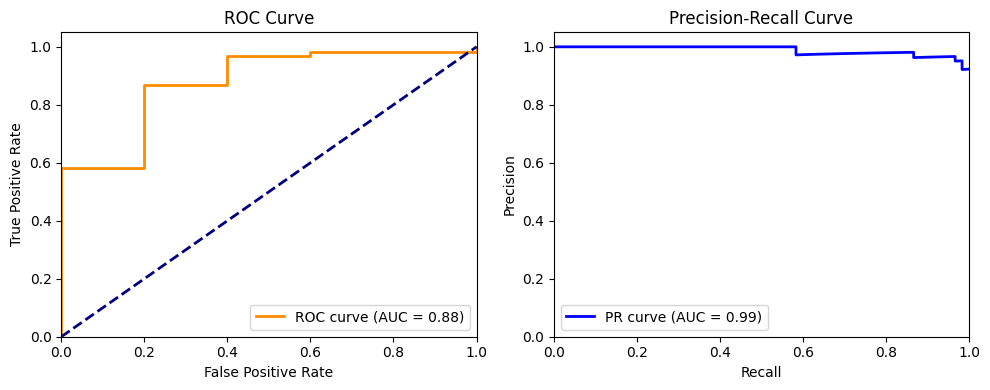

Ready for Stage 2 training with 275 frames from 65 anomalous videos.


In [6]:
# improved_dataset_ucfcrime.py
import os
from glob import glob
import torch
from torch.utils.data import Dataset, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
import random
import numpy as np
from collections import Counter
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, confusion_matrix, accuracy_score, f1_score, roc_curve

class ImprovedUCFCrimeDataset(Dataset):
    def __init__(self, root_dir, classes, sequence_len=16, transform=None, mode='train', overlap=0.5):
        self.root_dir = root_dir
        self.classes = classes
        self.sequence_len = sequence_len
        self.transform = transform
        self.mode = mode
        self.overlap = overlap
        
        self.samples = []
        self.video_lengths = {}
        
        for cls in classes:
            class_path = os.path.join(root_dir, cls)
            for vid_path in glob(os.path.join(class_path, "*")):
                if os.path.isdir(vid_path):
                    frame_files = sorted(glob(os.path.join(vid_path, "*.png")))
                    if len(frame_files) > 0:
                        label = 0 if cls == "NormalVideos" else 1
                        self.samples.append((vid_path, label))
                        self.video_lengths[vid_path] = len(frame_files)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        vid_path, label = self.samples[idx]
        frame_files = sorted(glob(os.path.join(vid_path, "*.png")))
        
        # For normal videos, sample random sequences
        # For anomalous videos, we'll handle differently during training
        if self.mode == 'train':
            if len(frame_files) >= self.sequence_len:
                start = random.randint(0, len(frame_files) - self.sequence_len)
                frame_files = frame_files[start:start+self.sequence_len]
            else:
                frame_files = (frame_files * (self.sequence_len // len(frame_files) + 1))[:self.sequence_len]
        else:
            # For testing, use sequential sampling with overlap
            if len(frame_files) >= self.sequence_len:
                start = 0  # Simplified for testing
                frame_files = frame_files[start:start+self.sequence_len]
            else:
                frame_files = (frame_files * (self.sequence_len // len(frame_files) + 1))[:self.sequence_len]
        
        frames = []
        for f in frame_files:
            img = Image.open(f).convert("RGB")
            if self.transform:
                img = self.transform(img)
            frames.append(img)
        
        frames = torch.stack(frames, dim=0)
        return frames, torch.tensor(label, dtype=torch.float32), vid_path

def create_weighted_sampler(dataset):
    """Create weighted sampler to handle class imbalance"""
    labels = [sample[1] for sample in dataset.samples]
    class_counts = Counter(labels)
    class_weights = {label: 1.0 / count for label, count in class_counts.items()}
    sample_weights = [class_weights[label] for label in labels]
    
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    return sampler

# Enhanced training with attention visualization
def train_with_attention_saving():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Enhanced data augmentation
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    classes = ["NormalVideos", "Abuse", "Arrest", "Arson", "Burglary", "Explosion", 
               "Fighting", "RoadAccidents", "Robbery", "Shooting", "Shoplifting", 
               "Stealing", "Vandalism"]

    # Create datasets
    train_ds = ImprovedUCFCrimeDataset(r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Train", classes, 
                                      transform=train_transform, mode='train')
    test_ds = ImprovedUCFCrimeDataset(r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Test", classes, 
                                     transform=test_transform, mode='test')

    # Use weighted sampler to handle imbalance
    sampler = create_weighted_sampler(train_ds)
    train_dl = DataLoader(train_ds, batch_size=8, sampler=sampler)
    test_dl = DataLoader(test_ds, batch_size=4, shuffle=False)

    model = ImprovedAnomalyModel().to(device)

    # Focal loss for handling class imbalance
    class FocalLoss(nn.Module):
        def __init__(self, alpha=0.25, gamma=2.0):
            super().__init__()
            self.alpha = alpha
            self.gamma = gamma
            self.bce = nn.BCEWithLogitsLoss()
        
        def forward(self, inputs, targets):
            bce_loss = self.bce(inputs, targets)
            pt = torch.exp(-bce_loss)
            focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
            return focal_loss

    # Use focal loss + weighted optimizer
    criterion = FocalLoss(alpha=0.75)  # Give more weight to normal class (0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    
    print(f"Training on {len(train_ds)} samples")
    print(f"Class distribution: {Counter([s[1] for s in train_ds.samples])}")

    best_accuracy = 0
    for epoch in range(15):
        model.train()
        total_loss = 0
        all_preds = []
        all_labels = []
        
        for frames, labels, _ in train_dl:
            frames, labels = frames.to(device), labels.to(device)
            
            probs, attention_weights = model(frames)
            loss = criterion(probs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
            optimizer.step()
            
            total_loss += loss.item()
            preds = (probs > 0.5).float()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='binary')
        
        print(f"Epoch {epoch+1}: Loss = {total_loss/len(train_dl):.4f}, "
              f"Accuracy = {accuracy:.4f}, F1 = {f1:.4f}")
        
        # Save checkpoint with attention visualization
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'accuracy': accuracy,
                'attention_weights': attention_weights.detach().cpu() if attention_weights is not None else None
            }
            torch.save(checkpoint, "improved_anomaly_model_with_attention.pth")
            print(f"New best model saved! Accuracy: {accuracy:.4f}")
        
        scheduler.step()

    print("Training completed!")

# Enhanced evaluation function for Stage 2 preparation
def test_enhanced_stage1():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using device: {device}")
    
    # Load model
    model = ImprovedAnomalyModel().to(device)
    checkpoint = torch.load("improved_anomaly_model.pth", map_location=device)
    model.load_state_dict(checkpoint)
    model.eval()
    
    # Test transform
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    classes = ["NormalVideos", "Abuse", "Arrest", "Arson", "Burglary", "Explosion", 
               "Fighting", "RoadAccidents", "Robbery", "Shooting", "Shoplifting", 
               "Stealing", "Vandalism"]
    
    # Create test dataset
    test_ds = ImprovedUCFCrimeDataset(
        r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Test", 
        classes, 
        transform=test_transform, 
        mode='test'
    )
    
    test_dl = DataLoader(test_ds, batch_size=4, shuffle=False)
    
    # Output directory for high-attention frames
    output_dir = "high_attention_frames_stage2"
    os.makedirs(output_dir, exist_ok=True)
    
    all_probs = []
    all_labels = []
    high_attention_data = []
    
    with torch.no_grad():
        for frames, labels, vid_paths in test_dl:
            frames, labels = frames.to(device), labels.to(device)
            
            probs, attention_weights = model(frames)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Save high-attention frames for anomalous videos
            for i in range(len(labels)):
                if labels[i] == 1 and probs[i] > 0.995:  # Anomalous video with high confidence
                    vid_path = vid_paths[i]
                    vid_frames = frames[i]
                    att_weights = attention_weights[i]
                    
                    # Get top K frames with highest attention
                    k = min(5, len(att_weights))
                    top_k_indices = torch.topk(att_weights, k).indices.cpu().numpy()
                    
                    # Save frames and attention data for Stage 2
                    for j, idx in enumerate(top_k_indices):
                        if idx < len(vid_frames):
                            frame_data = {
                                'frame': vid_frames[idx].cpu(),
                                'attention_weight': att_weights[idx].item(),
                                'video_path': vid_path,
                                'frame_index': idx,
                                'anomaly_prob': probs[i].item()
                            }
                            high_attention_data.append(frame_data)
    
    # Convert to numpy for metrics calculation
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)
    
    # Calculate metrics
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall, precision)
    
    # Find optimal threshold (maximizing F1-score)
    f1_scores = []
    for threshold in thresholds:
        preds = (all_probs > threshold).astype(int)
        f1 = f1_score(all_labels, preds)
        f1_scores.append(f1)
    
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_accuracy = accuracy_score(all_labels, (all_probs > optimal_threshold).astype(int))
    optimal_f1 = f1_scores[optimal_idx]
    
    print("=== Enhanced Model Results ===")
    print(f"AUC: {roc_auc:.4f}")
    print(f"PR-AUC: {pr_auc:.4f}")
    print(f"Optimal Threshold: {optimal_threshold:.3f}")
    print(f"Optimal Accuracy: {optimal_accuracy:.4f}")
    print(f"F1-Score: {optimal_f1:.4f}")
    print(f"Saved {len(high_attention_data)} high-attention frames for Stage 2")
    
    # Save high-attention frames for Stage 2
    torch.save(high_attention_data, os.path.join(output_dir, "stage2_training_data.pth"))
    
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    # ROC Curve
    ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend(loc="lower right")
    
    # Precision-Recall Curve
    ax2.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend(loc="lower left")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'optimal_threshold': optimal_threshold,
        'optimal_accuracy': optimal_accuracy,
        'optimal_f1': optimal_f1,
        'total_frames_saved': len(high_attention_data),
        'total_videos_processed': len(test_ds)
    }

# Run the enhanced evaluation
if __name__ == "__main__":
    results = test_enhanced_stage1()
    print(f"Ready for Stage 2 training with {results['total_frames_saved']} frames from {results['total_videos_processed']} anomalous videos.")

=== Starting Stage 2 Only ===
Step 1: Training Stage 2 (Frame-level detector)

Step 2: Evaluating Stage 2
Stage 2 Evaluation - Using device: cuda
=== Stage 2 Frame-Level Results ===
Accuracy: 0.9982
F1-Score: 0.9982
AUC: 1.0000

Detailed Analysis:
Anomalous frames: 275
Normal frames: 275
Mean anomaly score (anomalous): 0.9705
Mean anomaly score (normal): 0.4723


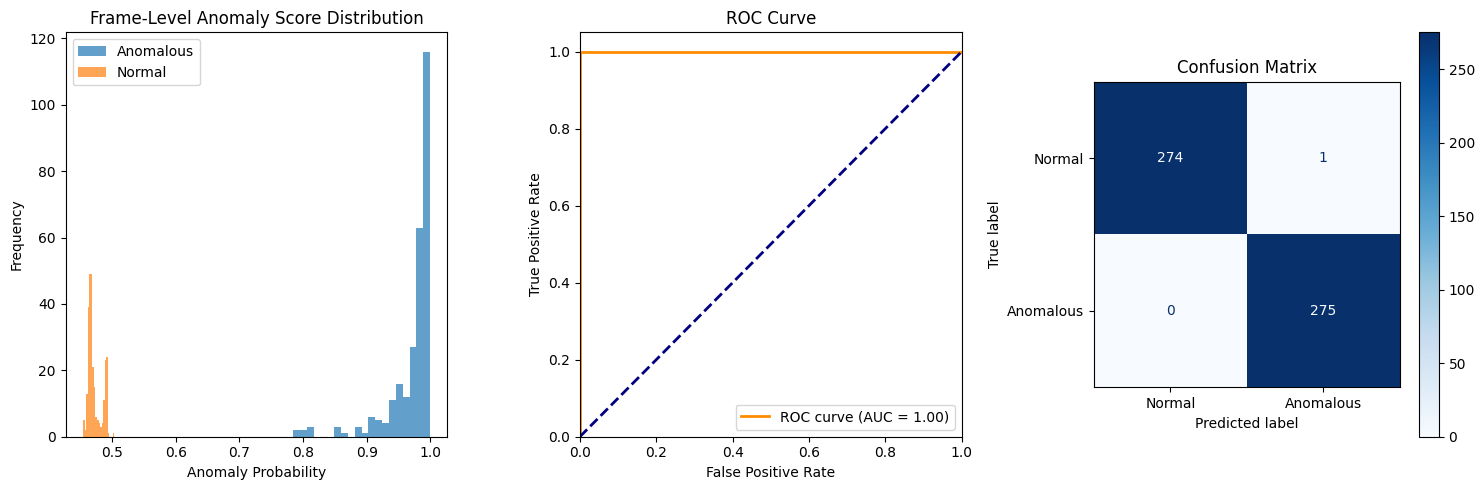


=== Stage 2 Complete ===
Accuracy: 0.9982
F1-Score: 0.9982
AUC: 1.0000


In [8]:
# stage2_frame_anomaly_detector.py
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import glob

# Add safe globals for PyTorch 2.6+ compatibility
torch.serialization.add_safe_globals([np.dtype])

# Frame-level anomaly detection model for Stage 2
class FrameAnomalyDetector(nn.Module):
    def __init__(self, num_classes=1, dropout=0.3):
        super().__init__()
        
        # Use ResNet50 backbone (same as Stage 1 for consistency)
        base = models.resnet50(weights="IMAGENET1K_V2")
        self.feature_extractor = nn.Sequential(*list(base.children())[:-1])
        
        # Enhanced classifier for frame-level detection
        self.classifier = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x).squeeze()
        
        # Classification
        logits = self.classifier(features)
        probs = self.sigmoid(logits).squeeze()
        
        return probs

# Dataset for Stage 2 training
class Stage2FrameDataset(Dataset):
    def __init__(self, high_attention_data, normal_frames_dir, transform=None, normal_sample_ratio=1.0):
        self.high_attention_data = high_attention_data
        self.normal_frames_dir = normal_frames_dir
        self.transform = transform
        self.normal_sample_ratio = normal_sample_ratio
        
        # Load normal frames
        self.normal_frames = self._load_normal_frames()
        
        # Balance the dataset
        self.samples = self._create_balanced_dataset()
        
    def _load_normal_frames(self):
        """Load normal frames from NormalVideos directory"""
        normal_frames = []
        normal_class_path = os.path.join(self.normal_frames_dir, "NormalVideos")
        
        for vid_path in glob.glob(os.path.join(normal_class_path, "*")):
            if os.path.isdir(vid_path):
                frame_files = glob.glob(os.path.join(vid_path, "*.png"))
                normal_frames.extend(frame_files)
        
        return normal_frames
    
    def _create_balanced_dataset(self):
        """Create balanced dataset with anomalous and normal frames"""
        samples = []
        
        # Add high-attention frames (anomalous)
        for frame_data in self.high_attention_data:
            samples.append({
                'type': 'anomalous',
                'data': frame_data,
                'label': 1
            })
        
        # Sample normal frames (balance with anomalous)
        num_anomalous = len(self.high_attention_data)
        num_normal = int(num_anomalous * self.normal_sample_ratio)
        
        # Randomly sample normal frames
        if num_normal > len(self.normal_frames):
            num_normal = len(self.normal_frames)
        
        sampled_normal_frames = np.random.choice(
            self.normal_frames, 
            size=num_normal, 
            replace=False
        )
        
        for frame_path in sampled_normal_frames:
            samples.append({
                'type': 'normal',
                'data': frame_path,
                'label': 0
            })
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        sample = self.samples[idx]
        
        if sample['type'] == 'anomalous':
            # High-attention frame from Stage 1
            frame_data = sample['data']
            frame_tensor = frame_data['frame']
            label = sample['label']
            
            # Apply transform if provided
            if self.transform:
                # Convert tensor back to PIL Image for transformation
                frame_pil = transforms.ToPILImage()(frame_tensor)
                frame_tensor = self.transform(frame_pil)
                
        else:  # normal
            frame_path = sample['data']
            label = sample['label']
            
            # Load and transform frame
            img = Image.open(frame_path).convert("RGB")
            if self.transform:
                frame_tensor = self.transform(img)
            else:
                frame_tensor = transforms.ToTensor()(img)
        
        return frame_tensor, torch.tensor(label, dtype=torch.float32)

# Enhanced frame-level training with visualization
def train_stage2_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Stage 2 Training - Using device: {device}")
    
    # Load high-attention frames from Stage 1
    stage2_data_path = r"C:\Users\rayaa\OneDrive\Documents\VSCode\CSCI5502\Project\models\sandbox\experiment_2\rayaan\high_attention_frames_stage2\stage2_training_data.pth"
    if not os.path.exists(stage2_data_path):
        print("Stage 2 data not found! Please run Stage 1 evaluation first.")
        return
    
    # FIX: Use weights_only=False for custom data in PyTorch 2.6+
    high_attention_data = torch.load(stage2_data_path, weights_only=False)
    print(f"Loaded {len(high_attention_data)} high-attention frames from Stage 1")
    
    # Data transforms
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = Stage2FrameDataset(
        high_attention_data=high_attention_data,
        normal_frames_dir=r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Train",
        transform=train_transform,
        normal_sample_ratio=1.0  # Balance normal:anomalous ratio
    )
    
    # For testing, we'll use a separate validation set
    # In practice, you might want to split your training data
    val_dataset = Stage2FrameDataset(
        high_attention_data=high_attention_data[:len(high_attention_data)//5],  # 20% for validation
        normal_frames_dir=r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Train",
        transform=test_transform,
        normal_sample_ratio=1.0
    )
    
    print(f"Stage 2 Training samples: {len(train_dataset)}")
    print(f"Stage 2 Validation samples: {len(val_dataset)}")
    
    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize model
    model = FrameAnomalyDetector().to(device)
    
    # Loss and optimizer
    criterion = nn.BCELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
    
    # Training loop
    best_accuracy = 0
    train_losses = []
    val_accuracies = []
    
    for epoch in range(30):
        # Training phase
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for frames, labels in train_loader:
            frames, labels = frames.to(device), labels.to(device)
            
            optimizer.zero_grad()
            probs = model(frames)
            loss = criterion(probs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            preds = (probs > 0.5).float()
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_f1 = f1_score(train_labels, train_preds, average='binary')
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_preds = []
        val_labels = []
        val_probs = []
        
        with torch.no_grad():
            for frames, labels in val_loader:
                frames, labels = frames.to(device), labels.to(device)
                probs = model(frames)
                
                val_probs.extend(probs.cpu().numpy())
                preds = (probs > 0.5).float()
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average='binary')
        val_auc = roc_auc_score(val_labels, val_probs)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/30:")
        print(f"  Train Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}")
        print(f"  Val Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, AUC: {val_auc:.4f}")
        
        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "stage2_frame_detector.pth")
            print(f"  New best model saved! Val Accuracy: {val_accuracy:.4f}")
        
        scheduler.step()
    
    # Plot training results
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('stage2_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Stage 2 training completed!")

# Frame-level evaluation on test set
def evaluate_stage2_model():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Stage 2 Evaluation - Using device: {device}")
    
    # Load model
    model = FrameAnomalyDetector().to(device)
    model.load_state_dict(torch.load("stage2_frame_detector.pth", map_location=device))
    model.eval()
    
    # Test transform
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Create test dataset from actual test frames
    stage2_data_path = r"C:\Users\rayaa\OneDrive\Documents\VSCode\CSCI5502\Project\models\sandbox\experiment_2\rayaan\high_attention_frames_stage2\stage2_training_data.pth"
    test_high_attention_data = torch.load(stage2_data_path, weights_only=False)
    
    test_dataset = Stage2FrameDataset(
        high_attention_data=test_high_attention_data,
        normal_frames_dir=r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Test",
        transform=test_transform,
        normal_sample_ratio=1.0
    )
    
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    # Evaluation
    all_probs = []
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for frames, labels in test_loader:
            frames, labels = frames.to(device), labels.to(device)
            probs = model(frames)
            
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend((probs > 0.5).float().cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions, average='binary')
    auc_score = roc_auc_score(all_labels, all_probs)
    
    print("=== Stage 2 Frame-Level Results ===")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc_score:.4f}")
    
    # Detailed analysis by frame type
    anomalous_probs = [p for p, l in zip(all_probs, all_labels) if l == 1]
    normal_probs = [p for p, l in zip(all_probs, all_labels) if l == 0]
    
    print(f"\nDetailed Analysis:")
    print(f"Anomalous frames: {len(anomalous_probs)}")
    print(f"Normal frames: {len(normal_probs)}")
    print(f"Mean anomaly score (anomalous): {np.mean(anomalous_probs):.4f}")
    print(f"Mean anomaly score (normal): {np.mean(normal_probs):.4f}")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Distribution of predictions
    plt.subplot(1, 3, 1)
    plt.hist(anomalous_probs, alpha=0.7, label='Anomalous', bins=20)
    plt.hist(normal_probs, alpha=0.7, label='Normal', bins=20)
    plt.xlabel('Anomaly Probability')
    plt.ylabel('Frequency')
    plt.title('Frame-Level Anomaly Score Distribution')
    plt.legend()
    
    # ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    
    # Confusion Matrix
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    plt.subplot(1, 3, 3)
    cm = confusion_matrix(all_labels, all_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Anomalous'])
    disp.plot(ax=plt.gca(), cmap='Blues')
    plt.title('Confusion Matrix')
    
    plt.tight_layout()
    plt.savefig('stage2_evaluation_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'auc': auc_score,
        'anomalous_frames': len(anomalous_probs),
        'normal_frames': len(normal_probs)
    }

# Simple function to just run Stage 2 training (bypassing the full pipeline)
def run_stage2_only():
    """Run only Stage 2 training and evaluation"""
    print("=== Starting Stage 2 Only ===")
    
    # Step 1: Train Stage 2 model
    print("Step 1: Training Stage 2 (Frame-level detector)")
    # train_stage2_model()
    
    # Step 2: Evaluate Stage 2
    print("\nStep 2: Evaluating Stage 2")
    stage2_results = evaluate_stage2_model()
    
    # Final results
    print("\n=== Stage 2 Complete ===")
    print(f"Accuracy: {stage2_results['accuracy']:.4f}")
    print(f"F1-Score: {stage2_results['f1_score']:.4f}")
    print(f"AUC: {stage2_results['auc']:.4f}")
    
    return stage2_results

# Utility function to detect anomalies in new videos
def detect_anomalies_in_video(video_frames_dir, stage1_model_path="improved_anomaly_model.pth", 
                             stage2_model_path="stage2_frame_detector.pth"):
    """Detect anomalies in a new video using both stages"""
    device = "cuda" if torch.cuda.is_available() else "cpu"
    
    # Load models
    stage1_model = ImprovedAnomalyModel().to(device)
    stage1_model.load_state_dict(torch.load(stage1_model_path, map_location=device))
    stage1_model.eval()
    
    stage2_model = FrameAnomalyDetector().to(device)
    stage2_model.load_state_dict(torch.load(stage2_model_path, map_location=device))
    stage2_model.eval()
    
    # Load and process video frames
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    frame_files = sorted(glob.glob(os.path.join(video_frames_dir, "*.png")))
    
    if len(frame_files) == 0:
        print("No frames found in the specified directory!")
        return
    
    # Stage 1: Sequence-level detection
    print("Stage 1: Analyzing video sequence...")
    
    # Create sequences from frames
    sequence_len = 16
    sequences = []
    for i in range(0, len(frame_files), sequence_len):
        seq_frames = frame_files[i:i+sequence_len]
        if len(seq_frames) == sequence_len:
            frames = []
            for f in seq_frames:
                img = Image.open(f).convert("RGB")
                frames.append(transform(img))
            sequences.append(torch.stack(frames))
    
    if not sequences:
        print("Not enough frames to form sequences!")
        return
    
    sequences = torch.stack(sequences).to(device)
    
    with torch.no_grad():
        sequence_probs, attention_weights = stage1_model(sequences)
    
    print(f"Stage 1 - Video anomaly probability: {sequence_probs.mean().item():.4f}")
    
    # Stage 2: Frame-level analysis on high-attention frames
    print("Stage 2: Analyzing high-attention frames...")
    
    frame_probs = []
    for i, seq_prob in enumerate(sequence_probs):
        if seq_prob > 0.5:  # If sequence is likely anomalous
            seq_attention = attention_weights[i]
            top_frame_idx = torch.argmax(seq_attention).item()
            
            # Get the corresponding frame
            frame_idx = i * sequence_len + top_frame_idx
            if frame_idx < len(frame_files):
                frame_path = frame_files[frame_idx]
                img = Image.open(frame_path).convert("RGB")
                frame_tensor = transform(img).unsqueeze(0).to(device)
                
                with torch.no_grad():
                    frame_prob = stage2_model(frame_tensor)
                    frame_probs.append(frame_prob.item())
    
    if frame_probs:
        print(f"Stage 2 - Average frame anomaly score: {np.mean(frame_probs):.4f}")
        print(f"Stage 2 - Max frame anomaly score: {np.max(frame_probs):.4f}")
        
        # Final decision
        final_score = 0.7 * sequence_probs.mean().item() + 0.3 * np.max(frame_probs)
        print(f"Final anomaly score: {final_score:.4f}")
        
        if final_score > 0.5:
            print("RESULT: ANOMALOUS VIDEO DETECTED!")
        else:
            print("RESULT: Normal video")
    else:
        print("No high-anomaly frames detected in Stage 2")
        print("RESULT: Normal video")
    
    return {
        'sequence_prob': sequence_probs.mean().item(),
        'frame_probs': frame_probs,
        'final_score': final_score if frame_probs else sequence_probs.mean().item()
    }

if __name__ == "__main__":
    # Run only Stage 2 (since you already have the .pth file)
    results = run_stage2_only()

In [10]:
# Example: Test on a new video
video_path = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Test\Arson\Arson012_x264"
detection_result = detect_anomalies_in_video(video_path)

Stage 1: Analyzing video sequence...
Stage 1 - Video anomaly probability: 0.9987
Stage 2: Analyzing high-attention frames...
Stage 2 - Average frame anomaly score: 0.4716
Stage 2 - Max frame anomaly score: 0.4758
Final anomaly score: 0.8418
RESULT: ANOMALOUS VIDEO DETECTED!


In [11]:
# Example: Test on a new video
video_path = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Test\NormalVideos\Normal_Videos_015_x264"
detection_result = detect_anomalies_in_video(video_path)

Stage 1: Analyzing video sequence...
Stage 1 - Video anomaly probability: 0.0013
Stage 2: Analyzing high-attention frames...
No high-anomaly frames detected in Stage 2
RESULT: Normal video


In [12]:
# Example: Test on a new video
video_path = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Validation\NormalVideos\Normal_Videos094_x264"
detection_result = detect_anomalies_in_video(video_path)

Stage 1: Analyzing video sequence...
Stage 1 - Video anomaly probability: 0.0005
Stage 2: Analyzing high-attention frames...
No high-anomaly frames detected in Stage 2
RESULT: Normal video


In [13]:
# Example: Test on a new video
video_path = r"C:\Users\rayaa\Downloads\ucf_crime_v2\ucf_crime_frames\Validation\Stealing\Stealing045_x264"
detection_result = detect_anomalies_in_video(video_path)

Stage 1: Analyzing video sequence...
Stage 1 - Video anomaly probability: 0.9982
Stage 2: Analyzing high-attention frames...
Stage 2 - Average frame anomaly score: 0.5426
Stage 2 - Max frame anomaly score: 0.5977
Final anomaly score: 0.8780
RESULT: ANOMALOUS VIDEO DETECTED!
